# Lunar Lander - Reinforcement Learning Project

Mini project for practicing reinforcement learning. The goal is to make the agent capable of landing a lunar aircraft in a simulated environment. Here, I will use OpenAI Gymnasium for the lunar lander environment.
<br>
The agent's observation space consist of a state vector with 8 variables:
1. $(x,y)$ coordinates. The landing pad is at $(0,0)$.
2. Linear velocities $(\dot x,\dot y)$.
3. Angle $θ$.
4. Angular velocity $\dot θ$.
5. Booleans to represent whether each leg is in contact with the ground or not ($l$ and $r$).

Each action taken by the agent has a corresponding value:
1. Do nothing = 0
2. Fire right engine = 1
3. Fire main engine = 2
4. Fire left engine = 3

After every step, a reward is granted for the agent. The total reward of an episode is the sum for all the steps within that episode (already stated within the environment):

1. +100 for landing safely.
2. -100 for crashing.
3. -0.3 for each frame the main engine is firing.
4. -0.03 for each frame the side engine is firing.
5. +10 for each leg in contact with the ground.
6. Further decreased the more the lander is tilted.
7. Further increased/decreased if it took too long.
8. Further increased/decreased the closed/further the lander is to the landing pad.

## 0. Packages

In [1]:
!pip install pyvirtualdisplay

In [2]:
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 65.7 MB/s eta 0:00:00


In [3]:
import time
from collections import deque, namedtuple

import gymnasium as gym
from gymnasium.vector import SyncVectorEnv
import numpy as np
import pandas as pd
import PIL.Image
import tensorflow as tf
import random

import matplotlib.pyplot as plt
from pyvirtualdisplay import Display

In [4]:
from numpy.random import seed
# Set up virtual display to render environment
Display(visible=0, size=(840,480)).start()

# Set random seed
def set_all_seeds(seed_value=42):
    """
    Sets seeds for Python, NumPy, and TensorFlow.
    A common utility function to maximize reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

set_all_seeds()

In [5]:
# Set hyperparameters
BATCH_SIZE = 64
GAMMA = 0.995           # Discount factor
LEARNING_RATE = float(0.001)
TARGET_UPDATE = 10      # Learning update every _ time steps # too small, i expect
MEMORY_SIZE = 100_000   # Size of memory buffer

num_episodes = 20000
MAX_STEPS_PER_EPISODE = 1000   # standard for LunarLander
print_every = 10
min_eps = 0.01
max_eps_episode = 50
SOLVE_WINDOW = 100
SOLVE_SCORE = 200
SAVE_PATH = "lunar_lander.h5"

N_ENVS = 8

def moving_average(x, window=100):
    return np.convolve(x, np.ones(window)/window, mode="valid")

## 1. Load Environment

In [6]:
env = SyncVectorEnv(
    [lambda: gym.make("LunarLander-v3", render_mode="rgb_array") for _ in range(N_ENVS)]
)

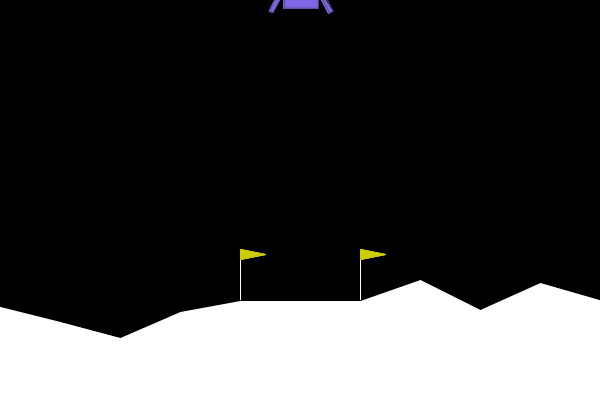

In [7]:
# Each time an episode is started, the environment is reset
state, info = env.reset()
PIL.Image.fromarray(env.envs[0].render())

In [8]:
# Quick sanity check for multiple environment
print(state.shape)
actions = np.zeros(N_ENVS, dtype=int)
next_state, reward, terminated, truncated, info = env.step(actions)
print(next_state.shape, reward.shape)

(8, 8)
(8, 8) (8,)


Before building NN, I need to know the size of the state vector and the number of valid actions from the environment

In [9]:
state_size = int(env.single_observation_space.shape[0])  # NN input size
num_actions = int(env.single_action_space.n)          # Output size

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: 8
Number of actions: 4


Each time the environment is reset, the agent can start taking actions in the environment using `.step()`




In [10]:
# Action map the agent
action_map = {
    0: "Do nothing",
    1: "Fire right engine",
    2: "Fire main engine",
    3: "Fire left engine"
}

## 2. Build DQN (Deep Q Network)

DQN is a learning function using bootstrapping + neural networks + replay.

If training on consecutive steps:
- Data is highly correlated
- Gradient descent is unstable
- The agent overfits recent behavior

Replay buffer solves this:
- Storing experiences
- Sampling random batches

In [11]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

This network outputs values, not an action. <br>
Input: `state = [x, y, vx, vy, angle, ang_vel, leg_l, leg_r]`<br>
Output: `[ Q(s,0), Q(s,1), Q(s,2), Q(s,3) ]`

In [12]:
def build_q_network():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(state_size,)), # (8,)
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(num_actions) # 4
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=tf.keras.losses.MeanSquaredError()
    )
    return model

## 3. Set DQN

In [ ]:
# DQN Agent
class DQNAgent:
    def __init__(self):
        self.q_net = build_q_network()
        self.target_net = build_q_network()
        self.target_net.set_weights(self.q_net.get_weights())

        self.memory = ReplayBuffer(MEMORY_SIZE)

        self.epsilon = 1.0
        self.steps = 0

    def select_action(self, state):
        """
        states:
          - shape (state_dim,)          -> single env
          - shape (N_ENVS, state_dim)   -> vector env
        returns:
          - int                          -> single env
          - np.ndarray (N_ENVS,)         -> vector env
        """
        # Ensure batch dimension
        if state.ndim == 1:
            state = state[np.newaxis, :]

        batch_size = state.shape[0]

        # Greedy exploration
        if np.random.rand() < self.epsilon:
            return env.action_space.sample()

        # Exploitation
        q_values = self.q_net(state, training=False)
        actions = tf.argmax(q_values,axis=1).numpy()
        return actions

    def store(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def train_step(self):
      if len(self.memory) < BATCH_SIZE:
          return

      # 1. Sample from replay buffer
      states, actions, rewards, next_states, dones = self.memory.sample(BATCH_SIZE)

      # 2. Explicit dtype casting (mitigating error on training)
      states = states.astype(np.float32)
      next_states = next_states.astype(np.float32)
      rewards = rewards.astype(np.float32)
      dones = dones.astype(np.float32)
      actions = actions.astype(np.int32)

      # 3. Compute target Q-values using target network
      next_q = self.target_net(next_states, training=False)
      max_next_q = tf.reduce_max(next_q, axis=1)

      targets = rewards + GAMMA * max_next_q * (1.0 - dones)

      # 4. Select Q(s,a) from current network
      masks = tf.one_hot(actions, num_actions)

      with tf.GradientTape() as tape:
          q_values = self.q_net(states, training=True)
          q_action = tf.reduce_sum(q_values * masks, axis=1)
          loss = tf.keras.losses.MSE(targets, q_action)

      # 5. Gradient descent
      grads = tape.gradient(loss, self.q_net.trainable_variables)
      self.q_net.optimizer.apply_gradients(
          zip(grads, self.q_net.trainable_variables)
      )

      # 6. Target network update (step-based)
      if self.steps % TARGET_UPDATE == 0:
          self.target_net.set_weights(self.q_net.get_weights())


High exploration for the first 50 episodes

In [ ]:
def update_epsilon(agent, episode):
    if episode < max_eps_episode:
        agent.epsilon = max(
            min_eps,
            1.0 - episode / max_eps_episode
        )
    else:
        agent.epsilon = min_eps

### 3.1. Training Loop

In the training process, I use moving average of the latests 100 rewards value instead of checking each rewards. This will result in a better generalization because it averages the overall score from 100 episodes instead of only shown 1 score from 1 episodes. When the average reach 200, the training ends.

In [ ]:
start = time.time()

agent = DQNAgent()
episode_rewards_list = []
episode_rewards = np.zeros(N_ENVS)

for episode in range(num_episodes):
    state, info = env.reset() # No seed to encourage generalization over memorization
    episode_rewards[:] = 0.0

    update_epsilon(agent, episode)

    for step in range(MAX_STEPS_PER_EPISODE):
        agent.steps += N_ENVS

        action = agent.select_action(state)          # shape: (N_ENVS,)
        next_state, reward, terminated, truncated, info = env.step(action)

        done = terminated | truncated                # shape: (N_ENVS,)

        # Store PER-ENV transitions
        for i in range(N_ENVS):
            agent.store(
                state[i],
                action[i],
                reward[i],
                next_state[i],
                done[i]
            )

        agent.train_step()

        state = next_state
        episode_rewards += reward

    mean_reward = episode_rewards.mean()
    episode_rewards_list.append(mean_reward)

    if len(episode_rewards_list) >= SOLVE_WINDOW:
        avg_reward = np.mean(episode_rewards_list[-SOLVE_WINDOW:])

        if episode % print_every == 0:
            print(
                f"Episode {episode:5d} | "
                f"Avg({SOLVE_WINDOW}): {avg_reward:7.2f} | "
                f"Epsilon: {agent.epsilon:.3f}"
            )

        if avg_reward >= SOLVE_SCORE:
            print(
                f"\nSolved at episode {episode}! "
                f"Average reward (last {SOLVE_WINDOW}): {avg_reward:.2f}"
            )
            agent.q_net.save(SAVE_PATH)
            print(f"Model saved to {SAVE_PATH}")
            break
    else:
        # Early episodes (not enough data for avg yet)
        if episode % print_every == 0:
            print(
                f"Episode {episode:5d} | "
                f"Reward (mean): {episode_rewards_list[-1]:7.1f} | "
                f"Epsilon: {agent.epsilon:.3f}"
            )

tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode     0 | Reward (mean): -1925.5 | Epsilon: 1.000
Episode    10 | Reward (mean): -1134.4 | Epsilon: 0.800
Episode    20 | Reward (mean):  -701.0 | Epsilon: 0.600
Episode    30 | Reward (mean):  -425.1 | Epsilon: 0.400
Episode    40 | Reward (mean):   -84.4 | Epsilon: 0.200
Episode    50 | Reward (mean):   -65.3 | Epsilon: 0.010
Episode    60 | Reward (mean):   236.9 | Epsilon: 0.010
Episode    70 | Reward (mean):   364.8 | Epsilon: 0.010
Episode    80 | Reward (mean):   -27.4 | Epsilon: 0.010
Episode    90 | Reward (mean):    -2.1 | Epsilon: 0.010
Episode   100 | Avg(100): -277.26 | Epsilon: 0.010
Episode   110 | Avg(100): -123.38 | Epsilon: 0.010
Episode   120 | Avg(100):  -21.45 | Epsilon: 0.010
Episode   130 | Avg(100):   39.04 | Epsilon: 0.010
Episode   140 | Avg(100):   63.87 | Epsilon: 0.010
Episode   150 | Avg(100):   65.21 | Epsilon: 0.010
Episode   160 | Avg(100):   25.27 | Epsilon: 0.010
Episode   170 | Avg(100):  -31.04 | Epsilon: 0.010
Episode   180 | Avg(100):  -52.0

KeyboardInterrupt: 

In [ ]:
agent.q_net.save(SAVE_PATH)

### 3.2. Learning Curves

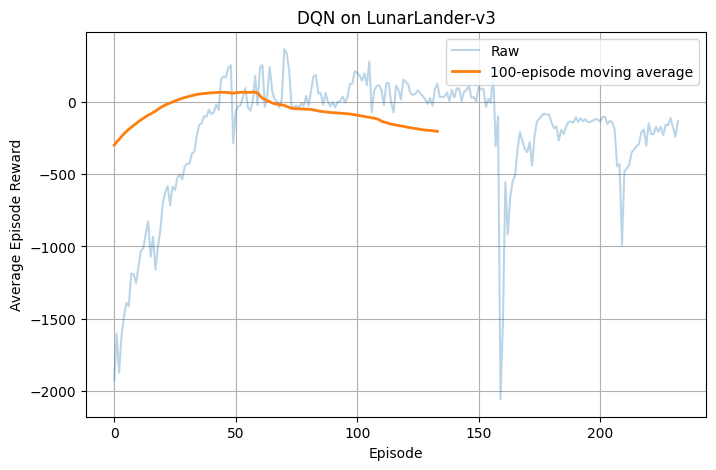

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(episode_rewards_list, alpha=0.3, label="Raw")
plt.plot(
    moving_average(episode_rewards_list, 100),
    label="100-episode moving average",
    linewidth=2
)
plt.xlabel("Episode")
plt.ylabel("Average Episode Reward")
plt.title("DQN on LunarLander-v3")
plt.legend()
plt.grid(True)
plt.show()


It is decaying and the model seems like going to perform worse overtime
<br>
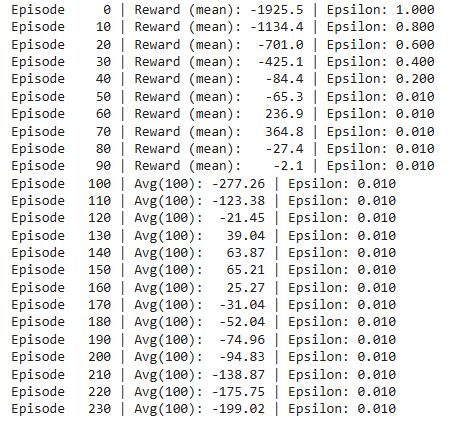

### 3.3. Animation

In [ ]:
render_env = gym.make(
    "LunarLander-v3",
    render_mode="rgb_array"
)
model = tf.keras.models.load_model("lunar_lander.h5")

In [ ]:
frames = []

state, info = render_env.reset()
done = False

while not done:
    state_input = state[np.newaxis, :].astype(np.float32)
    q_values = model(state_input, training=False)
    action = int(tf.argmax(q_values[0]))

    state, reward, terminated, truncated, info = render_env.step(action)
    done = terminated or truncated

    frame = render_env.render()
    frames.append(PIL.Image.fromarray(frame))

In [ ]:
frames[0].save(
    "lunar_lander.gif",
    save_all=True,
    append_images=frames[1:],
    duration=40,
    loop=0
)


IT DID NOT LAND AND KEEP ON MOVING WHYYYYYYYYY
<br>
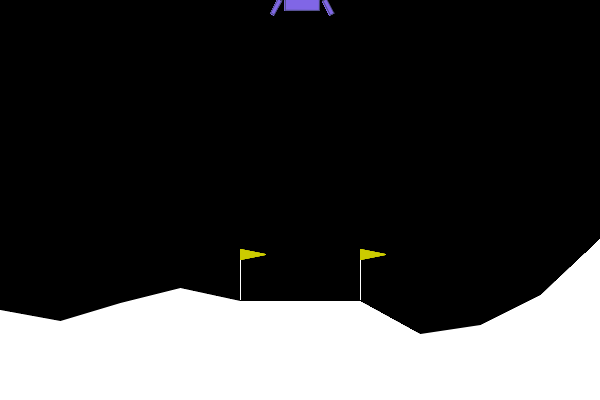

## 4. Double DQN

Since the model seems like learning bad things as a good things, lets tweak some parameter and things

In [13]:
eps_start = 1.0
min_eps = 0.05 # Make the exploration still exists
eps_decay_steps = 300_000 # Delayed exploration end by steps, not episodes
TARGET_UPDATE = 5000 # Stable target network
TRAIN_EVERY = 4 # Reduce noise, improve stability, better signal
SAVE_PATH_DDQN = "lunar_lander_DDQN.keras"

In [14]:
# DDQN Agent
class DDQNAgent:
    def __init__(self):
        self.q_net = build_q_network()
        self.target_net = build_q_network()
        self.target_net.set_weights(self.q_net.get_weights())

        self.memory = ReplayBuffer(MEMORY_SIZE)

        self.epsilon = 1.0
        self.steps = 0

    def select_action(self, state):
        """
        states:
          - shape (state_dim,)          -> single env
          - shape (N_ENVS, state_dim)   -> vector env
        returns:
          - int                          -> single env
          - np.ndarray (N_ENVS,)         -> vector env
        """
        # Ensure batch dimension
        if state.ndim == 1:
            state = state[np.newaxis, :]

        batch_size = state.shape[0]

        # Greedy exploration
        if np.random.rand() < self.epsilon:
          if batch_size == 1:
            return env.single_action_space.sample()
          else:
            return np.array([env.single_action_space.sample() for _ in range(batch_size)],
                            dtype=np.int32)

        # Exploitation
        q_values = self.q_net(state, training=False)
        actions = tf.argmax(q_values,axis=1).numpy()
        return actions

    def store(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def train_step(self):
      if len(self.memory) < BATCH_SIZE:
          return

      # 1. Sample from replay buffer
      states, actions, rewards, next_states, dones = self.memory.sample(BATCH_SIZE)

      # 2. Explicit dtype casting (mitigating error on training)
      states = states.astype(np.float32)
      next_states = next_states.astype(np.float32)
      rewards = rewards.astype(np.float32)
      dones = dones.astype(np.float32)
      actions = actions.astype(np.int32)

      # 3. Double DQN target computation

      # Action selection using ONLINE network
      next_actions = tf.argmax(
          self.q_net(next_states, training=False),
          axis=1
      )

      # Action evaluation using TARGET network
      next_q_target = self.target_net(next_states, training=False)
      next_q = tf.reduce_sum(
          next_q_target * tf.one_hot(next_actions, num_actions),
          axis=1
      )

      targets = rewards + GAMMA * next_q * (1.0 - dones)
      targets = tf.clip_by_value(targets, -200.0, 200.0) # Stabilize learning, prevents value blow up

      # 4. Select Q(s,a) from current network
      masks = tf.one_hot(actions, num_actions)

      with tf.GradientTape() as tape:
          q_values = self.q_net(states, training=True)
          q_action = tf.reduce_sum(q_values * masks, axis=1)
          loss = tf.reduce_mean(tf.keras.losses.Huber()(targets, q_action))

      # 5. Gradient descent
      grads = tape.gradient(loss, self.q_net.trainable_variables)
      self.q_net.optimizer.apply_gradients(
          zip(grads, self.q_net.trainable_variables)
      )

      # 6. Target network update (step-based)
      if self.steps % TARGET_UPDATE == 0:
          self.target_net.set_weights(self.q_net.get_weights())


### 4.1. Training Loop

In [15]:
start = time.time()

agent = DDQNAgent()
best_avg_reward = -np.inf

episode_rewards_list = []
episode_rewards = np.zeros(N_ENVS)

for episode in range(num_episodes):
    state, info = env.reset()
    episode_rewards[:] = 0.0

    for step in range(MAX_STEPS_PER_EPISODE):
        agent.steps += N_ENVS

        agent.epsilon = max(min_eps, eps_start - agent.steps / eps_decay_steps)

        action = agent.select_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)

        done = terminated | truncated

        for i in range(N_ENVS):
            agent.store(
                state[i],
                action[i],
                reward[i],
                next_state[i],
                done[i]
            )

        if agent.steps % TRAIN_EVERY == 0 and len(agent.memory)>=10_000:
          agent.train_step()
        state = next_state
        episode_rewards += reward

        if done.all():
            break

    mean_reward = episode_rewards.mean()
    episode_rewards_list.append(mean_reward)

    if len(episode_rewards_list) >= SOLVE_WINDOW:
        avg_reward = np.mean(episode_rewards_list[-SOLVE_WINDOW:])

        # BEST MODEL CHECKPOINT
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            agent.q_net.save("best_lunar_lander_DDQN.keras")
            print(
                f"New best model saved at episode {episode} | "
                f"Avg({SOLVE_WINDOW}) = {avg_reward:.2f}"
            )

        if episode % print_every == 0:
            print(
                f"Episode {episode:5d} | "
                f"Avg({SOLVE_WINDOW}): {avg_reward:7.2f} | "
                f"Epsilon: {agent.epsilon:.3f}"
            )

        if avg_reward >= SOLVE_SCORE:
            print(
                f"\nSolved at episode {episode}! "
                f"Average reward (last {SOLVE_WINDOW}): {avg_reward:.2f}"
            )
            agent.q_net.save(SAVE_PATH_DDQN)
            print(f"Model saved to {SAVE_PATH_DDQN}")
            break

    else:
        if episode % print_every == 0:
            print(
                f"Episode {episode:5d} | "
                f"Reward (mean): {mean_reward:7.1f} | "
                f"Epsilon: {agent.epsilon:.3f}"
            )

tot_time = time.time() - start
print(f"\nTotal Runtime: {tot_time:.2f} s ({tot_time/60:.2f} min)")

Episode     0 | Reward (mean): -1953.8 | Epsilon: 0.973
Episode    10 | Reward (mean):  -654.9 | Epsilon: 0.707
Episode    20 | Reward (mean):  -110.3 | Epsilon: 0.440
Episode    30 | Reward (mean):   -34.3 | Epsilon: 0.173
Episode    40 | Reward (mean):   -47.3 | Epsilon: 0.050
Episode    50 | Reward (mean):   -24.7 | Epsilon: 0.050
Episode    60 | Reward (mean):   -52.8 | Epsilon: 0.050
Episode    70 | Reward (mean):   -10.6 | Epsilon: 0.050
Episode    80 | Reward (mean):    27.7 | Epsilon: 0.050
Episode    90 | Reward (mean):   318.0 | Epsilon: 0.050
New best model saved at episode 99 | Avg(100) = -116.91
New best model saved at episode 100 | Avg(100) = -91.31
Episode   100 | Avg(100):  -91.31 | Epsilon: 0.050
New best model saved at episode 101 | Avg(100) = -67.07
New best model saved at episode 102 | Avg(100) = -47.56
New best model saved at episode 103 | Avg(100) = -26.46
New best model saved at episode 104 | Avg(100) = -7.33
New best model saved at episode 105 | Avg(100) = 10.45

### 4.2. Learning Curve

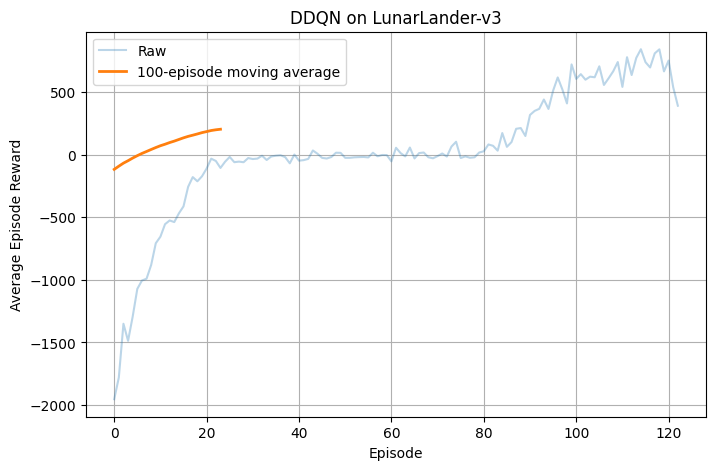

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(episode_rewards_list, alpha=0.3, label="Raw")
plt.plot(
    moving_average(episode_rewards_list, 100),
    label="100-episode moving average",
    linewidth=2
)
plt.xlabel("Episode")
plt.ylabel("Average Episode Reward")
plt.title("DDQN on LunarLander-v3")
plt.legend()
plt.grid(True)
plt.show()


### 4.3. Animation

In [20]:
render_env = gym.make(
    "LunarLander-v3",
    render_mode="rgb_array"
)
model = tf.keras.models.load_model("lunar_lander_DDQN.keras")

In [21]:
frames = []

state, info = render_env.reset()
done = False

while not done:
    state_input = state[np.newaxis, :].astype(np.float32)
    q_values = model(state_input, training=False)
    action = int(tf.argmax(q_values[0]))

    state, reward, terminated, truncated, info = render_env.step(action)
    done = terminated or truncated

    frame = render_env.render()
    frames.append(PIL.Image.fromarray(frame))

In [22]:
frames[0].save(
    "lunar_lander_DDQN2.gif",
    save_all=True,
    append_images=frames[1:],
    duration=40,
    loop=0
)


It performed well!
<br>
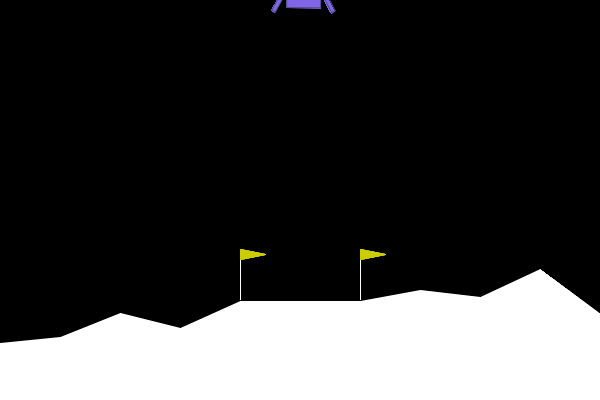

## 5. Conclusion

### **1. DQN was an essential first step**
Deep Q-Networks enable reinforcement learning in high dimensional and continuous state spaces by introducing 3 critical mechanisms:
1. Experience replay -> decorrelate samples
2. Target networks -> stabilize DQN learning by separating to learning network (updated constantly) and target network (updated every xxx step)  
3. ϵ greedy exploration -> balance exploration and exploitation

These mechanisms allow DQN to learn meaningful control policies. However, during longer training, it was observed that DQN:
1. Exhibits high variance in performance
2. Collapse and worsen after early success spike

Why? Because in DQN, the target value is overestimated. Regular DQN uses the same network for both choose which action is best AND estimate how good that action is. This overestimation bias can lead to:
1. Picking actions with noisy Q-value estimates
2. Overconfident but unstable (learning bad over time)

### **2. DDQN to overcome the DQN limitations**
Double Deep Q-Networks fixes this by splitting the network:
1. Main network -> picks which action looks best
2. Target network -> evaluate how good that action actually is (imagine having a second opinion), reducing overestimation bias

### **3. Role of hyperparameter adjustments**
The goal is to stabilizing the learning process, rather than speeding up:
- Slower ϵ decay -> ensure sufficient exploration before exploitation
- Higher minimum ϵ -> prevent premature convergence
- Less frequent target network update -> stabilizing
- Training every N steps -> reduce noise
- Huber loss and value clipping -> prevent extreme updates (MSE => square average => extreme score)

<br>As the environments become more complex, stability is more important than speed.
<br>
<br>Lunar lander environment => complex physics